In [1]:
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 2.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

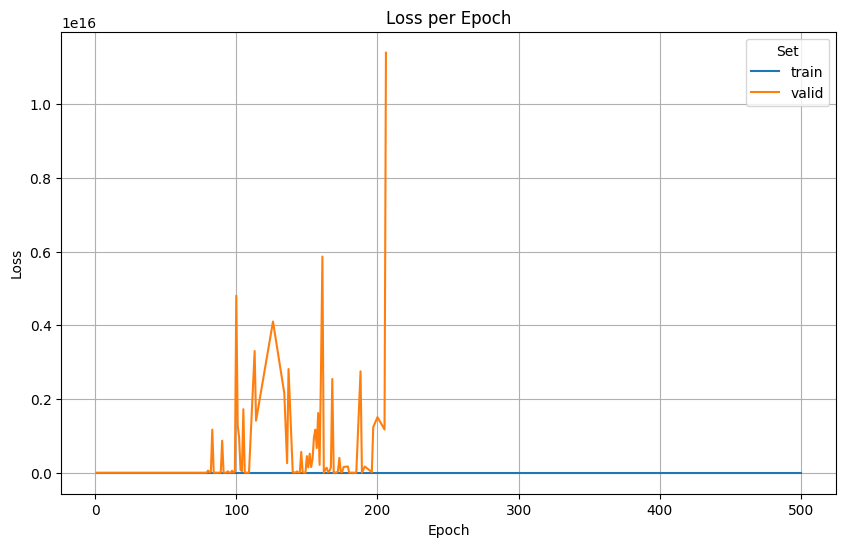

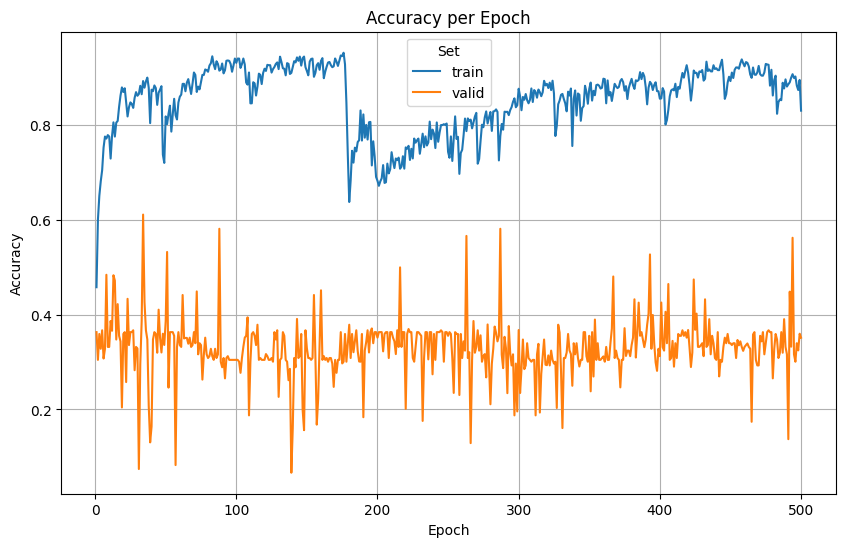

In [4]:
df = pd.read_csv('loss_dict.csv') 

# Filtro
start_epoch = 1
end_epoch = 500
df = df[(df['epoch'] >= start_epoch) & (df['epoch'] <= end_epoch)]

# Loss
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='epoch', y='loss', hue='set')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(title='Set')
plt.grid(True)
plt.show()

# Acc
plt.figure(figsize=(10, 6))
sns.lineplot(data=df, x='epoch', y='acc', hue='set')
plt.title('Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(title='Set')
plt.grid(True)
plt.show()
